In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text, total_barely_true_counts, total_false_counts, total_half_true_counts, total_mostly_true_counts) = parse_data_line(line)
            raw_data.append((text, label, total_barely_true_counts, total_false_counts, total_half_true_counts, total_mostly_true_counts))


def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label, total_barely_true_counts, total_false_counts, total_half_true_counts, total_mostly_true_counts) in raw_data[:num_training_samples]:
        # Update the dictionary
        dictionary = (to_feature_vector(pre_process(text)))
        dictionary['total_barely_true_counts'] = total_barely_true_counts
        dictionary['total_false_counts'] = total_false_counts
        dictionary['total_half_true_counts'] = total_half_true_counts
        dictionary['total_mostly_true_counts'] = total_mostly_true_counts
        train_data.append((dictionary,label))
    for (text, label, total_barely_true_counts, total_false_counts, total_half_true_counts, total_mostly_true_counts) in raw_data[num_training_samples:]:
        dictionary = (to_feature_vector(pre_process(text)))
        dictionary['total_barely_true_counts'] = total_barely_true_counts
        dictionary['total_false_counts'] = total_false_counts
        dictionary['total_half_true_counts'] = total_half_true_counts
        dictionary['total_mostly_true_counts'] = total_mostly_true_counts
        test_data.append((dictionary,label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    label = convert_label(data_line[1])
    statement = data_line[2]
    total_barely_true_counts = data_line[8]
    total_false_counts = data_line[9]
    total_half_true_counts = data_line[10]
    total_mostly_true_counts = data_line[11]
    return (label, statement, total_barely_true_counts, total_false_counts, total_half_true_counts, total_mostly_true_counts)

In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation
import nltk
import re
nltk.download('punkt')

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separate punctuation at ends of
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)  # separate punctuation at beginning of words
    text = re.split(r"\s+",text) # divide strings into words 
    tokens = [t.lower() for t in text] # lower case
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#[word.lower() for word in word_tokenize(text) if word not in punctuation]

# Question 2: Basic Feature Extraction (20 marks)

In [7]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    result = {}
    for token in tokens:
        if token not in result:
            result[token] = 0
        result[token] += 1
        if token not in global_feature_dict:
            global_feature_dict[token] = 0
        global_feature_dict[token] += 1
    return result

In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [9]:
#solution
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score



def cross_validate(dataset, folds):
    results=[]
    cv_results = []
    accuracy = []
    fold_size = int(len(dataset)/folds) + 1
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        train_set = dataset[:i] + dataset[i+fold_size:]
        valid_set = dataset[i:i+fold_size]
        samples, labels = map(list, zip(*valid_set))
        classifier = train_classifier(train_set)
        #y_predict
        predictions = predict_labels(samples, classifier)
        results += predictions
        #y_true = label 
        y_true = [x[1] for x in valid_set]
        cv_results.append(precision_recall_fscore_support(y_true, predictions, average='weighted'))
        accuracy.append(accuracy_score(y_true, predictions))

    train_set_label = [sample[1] for sample in dataset]    
    print(classification_report(train_set_label, results))    
# Average calculation of values oer 10 fold runs
    cv_results = np.array(cv_results)
    cv_results = [np.mean(cv_results[:,0]), np.mean(cv_results[:,1]), np.mean(cv_results[:,2])]

    accuracy = np.asarray(accuracy)
    accuracy = np.mean(accuracy)

    print('The overall precision is {}'
          '\nrecall score is {}'
          '\nf1 score is {}'
          '\naccuracy is {}'.format(cv_results[0],cv_results[1],cv_results[2],accuracy))

    predicted_label_data= []
    for i in range(len(dataset)):
        list_dataset = list(dataset[i])
        list_dataset = list_dataset + [results[i]]
        predicted_label_data.append(list_dataset)

    return cv_results, predicted_label_data





In [10]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [11]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')


split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13560


In [12]:
cv_results, predicted_label_data = cross_validate(train_data, 10)

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.60      0.60      0.60      3562
        REAL       0.69      0.69      0.69      4630

    accuracy                           0.65      8192
   macro avg       0.64      0.64      0.64      8192
weighted avg       0.65      0.65      0.65      8192

The overall precision is 0.6515008382044486
recall score is 0.6506584164363811
f1 score is 0.6507457214640542
accuracy is 0.6506

# 4. Error Analysis (10 marks)

In [13]:
def crossValidate(dataset, folds):
    cv_results = []
    accuracy = []
    shuffle(dataset)
    foldSize = int(len(dataset)/folds)
    for i in range(0,len(dataset),foldSize):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print ("fold start %d foldSize %d" % (i, foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[0:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_pred = predictLabels(myTestData, classifier)
#         review,label = zip(*myTestData)
#         y_true = label
        y_true = [x[1] for x in myTestData]
#         y_true = classifier.classify(map(lambda x: x[1], myTestData))
        cv_results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        accuracy.append(accuracy_score(y_true, y_pred))

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

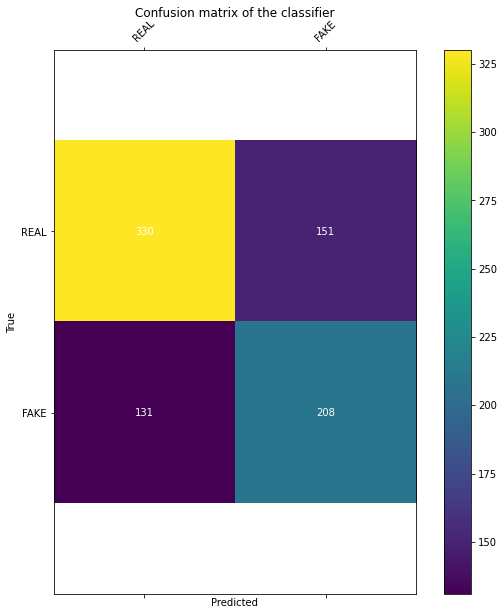

In [15]:
labels = ['REAL', 'FAKE']
train_data_label = [sample[1] for sample in predicted_label_data[:820]]
train_predict_label = [sample[2] for sample in predicted_label_data[:820]]
confusion_matrix_heatmap(train_data_label, train_predict_label, labels)

false_positive = []
false_negative = []
for i in range(len(train_data_label)):
    if predicted_label_data[i][1] == 'FAKE' and predicted_label_data[i][2] == 'REAL':
        false_negative.append(predicted_label_data[i])
    if predicted_label_data[i][1] == 'REAL' and predicted_label_data[i][2] == 'FAKE':
        false_positive.append(predicted_label_data[i])

def file_print_out(false):
    raw_data_spilt = [pre_process(text[0]) for text in raw_data]
    false_list = [list(text[0]) for text in false]
    output_list = []
    for tokens_1 in false_list:
      for i in range(len(raw_data_spilt)):
        if all(list(word in raw_data_spilt[i] for word in tokens_1)):
            output_list.append(raw_data[i])
    print(output_list)




In [16]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    print(len(train_data))
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    accuracy = np.mean(np.array(accuracy_score(test_true, test_pred)))
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print("Accuracy:%f" % accuracy)

({'the': 2, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1, 'total_barely_true_counts': '1', 'total_false_counts': '3', 'total_half_true_counts': '4', 'total_mostly_true_counts': '6'}, 'REAL')
8192
Training Classifier...
Done training!
Precision: 0.644901
Recall: 0.645193
F Score:0.645034
Accuracy:0.645193
